# Import Libraries 

In [16]:
from os import listdir
from os.path import isfile, join

import tensorflow as tf

import logging
import numpy as np
import pandas as pd
import sys
import tensorflow_lattice as tfl
from tensorflow import feature_column as fc
logging.disable(sys.maxsize)
import random
#import pydot
#import graphviz
from tensorflow.keras.utils import plot_model
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

#import pydot_ng as pydot
#pydot.find_graphviz()

import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'axes.unicode_minus': False
})
matplotlib.rcParams['axes.unicode_minus'] = False
%matplotlib inline
LEARNING_RATE = 0.5
BATCH_SIZE = 128
NUM_EPOCHS = 15

# Create Data

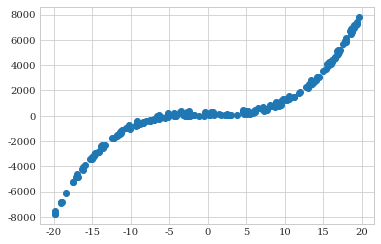

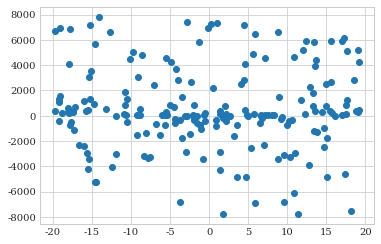

In [17]:
x = np.random.uniform(-20, 20, 200)
y = np.random.uniform(-20, 20, 200)
out = np.add(y**2, x**3)
plt.rc('text', usetex=False)
plt.figure()
plt.scatter(x, out)
plt.figure()
plt.scatter(y, out)

X = pd.DataFrame(list(zip(x,y)), columns=["x", "y"])

Y = pd.DataFrame(out, columns=["out"])


# Define functions for working with data

In [18]:
def train_test_split_multioutput(x_df, y_df, train_percent):
    x_len = len(x_df)
    y_len = len(y_df)
    x_indices = random.sample(range(0, x_len), int(x_len*train_percent))
    x_train = x_df.loc[x_indices]
    x_test = x_df.drop(x_indices)
    y_indices = random.sample(range(0, y_len), int(y_len*train_percent))
    y_train = y_df.loc[y_indices]
    y_test = y_df.drop(y_indices)
    x_train = x_train.reset_index()
    x_test = x_test.reset_index()
    y_train = y_train.reset_index()
    y_test = y_test.reset_index()
    return(x_train, x_test, y_train, y_test)



# Split into training and testing

In [19]:
random.seed(1)
X_train,X_test,y_train,y_test = train_test_split_multioutput(X,Y,0.66)

# Creating Calibrators and Inputs 

In [20]:
lattice_sizes = [5, 5]
model_inputs = []
lattice_inputs = []

########x calibrator#############
x_input = tf.keras.layers.Input(shape=[1], name='x')
model_inputs.append(x_input)
x_calibrator = tfl.layers.PWLCalibration(
   input_keypoints = np.quantile(
      X_train['x'], np.linspace(0.0, 1.0, num=5)),
    dtype=tf.float32,
    output_min=0.0,
    output_max=lattice_sizes[0]-1.0,
    kernel_initializer='equal_slopes',
    name='x_calib',
    #kernel_regularizer=('wrinkle',0.0, 1e-4),
    monotonicity='increasing'
)(
    x_input)
lattice_inputs.append(x_calibrator)

##########y calibrator##################
y_input = tf.keras.layers.Input(shape=[1], name='y')
model_inputs.append(y_input)
y_calibrator = tfl.layers.PWLCalibration(
   input_keypoints =  np.quantile(
      X_train['y'], np.linspace(0.0, 1.0, num=5)),
    dtype=tf.float32,
    output_min=0.0,
    output_max=lattice_sizes[1]-1.0,
    kernel_initializer='equal_slopes',
    name='y_calib',
    #kernel_regularizer=('wrinkle',0.0, 1e-4),
    #monotonicity='increasing'
)(
   y_input)
lattice_inputs.append(y_calibrator)


# Create Lattice Layer

In [35]:
lattice = tfl.layers.Lattice(
    lattice_sizes = lattice_sizes,
    monotonicities=['increasing', 'none'],
    #monotonicities=['none'],
    name='lattice',
)(
    lattice_inputs) 

model_output = tfl.layers.PWLCalibration(
    input_keypoints=np.linspace(y_train['out'].min(), y_train['out'].max(), 10),
    name='output_calib',
)(
    lattice)


# Create Functional Model

In [ ]:
model = tf.keras.models.Model(
    inputs=model_inputs,
    outputs=model_output)
feature_names = ['x', 'y']
features = np.split(
    X_train[feature_names].values.astype(np.float32),
    indices_or_sections=len(feature_names),
    axis=1)
target=y_train[['out']].values.astype(np.float32)
for lr in range(1, 100, 10):
    model.compile(
    loss=tf.keras.losses.mean_squared_error,
    optimizer=tf.keras.optimizers.Adam(lr))
    for batch_size_curr in range(10, 100, 10):
        model.fit(
       features,
       target,
       batch_size=batch_size_curr,
       epochs=100,
       shuffle=False,
       validation_split=0.3,
       verbose=0)
        print(lr)
        print(batch_size_curr)
        model.evaluate(features,target)
        print()


1
10
5/5 [==============================] - 0s 4ms/step - loss: 10365640.0000

1
20
5/5 [==============================] - 0s 4ms/step - loss: 10201525.0000

1
30
5/5 [==============================] - 0s 3ms/step - loss: 10225829.0000

1
40
5/5 [==============================] - 0s 4ms/step - loss: 10175977.0000

1
50
5/5 [==============================] - 0s 3ms/step - loss: 10157592.0000

1
60
5/5 [==============================] - 0s 4ms/step - loss: 10150253.0000

1
70
5/5 [==============================] - 0s 5ms/step - loss: 10148112.0000

1
80
5/5 [==============================] - 0s 3ms/step - loss: 10144806.0000

1
90
5/5 [==============================] - 0s 4ms/step - loss: 10200149.0000

11
10
5/5 [==============================] - 1s 3ms/step - loss: 10145033.0000

11
20
5/5 [==============================] - 0s 3ms/step - loss: 10166848.0000

11
30
5/5 [==============================] - 0s 5ms/step - loss: 10295537.0000

11
40
5/5 [==============================] - 0s 4

In [61]:
model.get_weights()

[array([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], dtype=float32),
 array([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], dtype=float32),
 array([[ -8519.795   ],
        [   -48.068375],
        [ -2636.7852  ],
        [ -5831.952   ],
        [-11404.8     ],
        [  1885.4587  ],
        [   -48.068375],
        [ -2636.7852  ],
        [ -4544.597   ],
        [ -3774.2324  ],
        [  1885.4587  ],
        [   -48.068375],
        [ -2636.7852  ],
        [ -4544.597   ],
        [ -1755.3783  ],
        [  3073.7473  ],
        [   -48.068375],
        [ -2636.7852  ],
        [ -1272.6658  ],
        [    35.931835],
        [  3518.556   ],
        [  2043.1025  ],
        [ -1243.2361  ],
        [  -507.43698 ],
        [   683.5707  ]], dtype=float32),
 array([[ 676.9177 ],
        [-109.04347],
        [-451.78   ],
        [-128.15869],
        [1354.7006 ],
        [1208.9294 ],
        [-372.74802],
        [ 985.97485],
        

In [16]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
y (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
x_calib (PWLCalibration)        (None, 1)            5           x[0][0]                          
__________________________________________________________________________________________________
y_calib (PWLCalibration)        (None, 1)            5           y[0][0]                          
____________________________________________________________________________________________

7915.498

# View Performance on Training Set

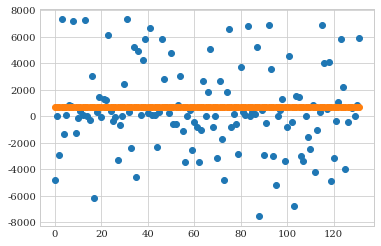

In [55]:
index = range(0, 132)
plt.scatter(index, y_train['out'])
plt.scatter(index, model.predict(features))